<a href="https://colab.research.google.com/github/shelbybachman/neuromatch-academy-2021/blob/main/W0D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: LIF Neuron Part II
**Week 0, Day 2: Python Workshop 2**

**By Neuromatch Academy**

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team

__Content reviewers:__ Michael Waskom, Karolina Stosio, Spiros Chavlis

__Production Editor:__ Ella Batty

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
## Tutorial objectives
We learned basic Python and NumPy concepts in the previous tutorial. These new and efficient coding techniques can be applied repeatedly in tutorials from the NMA course, and elsewhere. 

In this tutorial, we'll introduce spikes in our LIF neuron and evaluate the refractory period's effect in spiking dynamics!


---
# Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo

In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Helper functions

t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere


def plot_all(t_range, v, raster=None, spikes=None, spikes_mean=None):
  """
  Plots Time evolution for
  (1) multiple realizations of membrane potential
  (2) spikes
  (3) mean spike rate (optional)

  Args:
    t_range (numpy array of floats)
        range of time steps for the plots of shape (time steps)

    v (numpy array of floats)
        membrane potential values of shape (neurons, time steps)

    raster (numpy array of floats)
        spike raster of shape (neurons, time steps)

    spikes (dictionary of lists)
        list with spike times indexed by neuron number

    spikes_mean (numpy array of floats)
        Mean spike rate for spikes as dictionary

  Returns:
    Nothing.
  """

  v_mean = np.mean(v, axis=0)
  fig_w, fig_h = plt.rcParams['figure.figsize']
  plt.figure(figsize=(fig_w, 1.5 * fig_h))

  ax1 = plt.subplot(3, 1, 1)
  for j in range(n):
    plt.scatter(t_range, v[j], color="k", marker=".", alpha=0.01)
  plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
  plt.xticks([])
  plt.ylabel(r'$V_m$ (V)')

  if raster is not None:
    plt.subplot(3, 1, 2)
    spikes_mean = np.mean(raster, axis=0)
    plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')

  else:
    plt.subplot(3, 1, 2, sharex=ax1)
    for j in range(n):
      times = np.array(spikes[j])
      plt.scatter(times, j * np.ones_like(times), color="C0", marker=".", alpha=0.2)

  plt.xticks([])
  plt.ylabel('neuron')

  if spikes_mean is not None:
    plt.subplot(3, 1, 3, sharex=ax1)
    plt.plot(t_range, spikes_mean)
    plt.xlabel('time (s)')
    plt.ylabel('rate (Hz)')

  plt.tight_layout()
  plt.show()

---
# Section 1: Histograms


In [4]:
# @title Video 1: Histograms
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1GC4y1h7Ex", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="J24tne-IwvY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

![histogram statistics](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/histogram_statistics.png)

Another important statistic is the sample [histogram](https://en.wikipedia.org/wiki/Histogram). For our LIF neuron it provides an approximate representation of the distribution of membrane potential $V_m(t)$ at time $t=t_k\in[0,t_{max}]$. For $N$ realizations $V\left(t_k\right)$ and $J$ bins is given by:
 
\begin{align*}
\\
N = \sum_{j=1}^{J} m_j\\
\\
\end{align*}

where $m_j$ is a function that counts the number of samples $V\left(t_k\right)$ that fall into bin $j$.

The function `plt.hist(data, nbins)` plots an histogram of `data` in `nbins` bins. The argument `label` defines a label for `data` and `plt.legend()` adds all labels to the plot.

    plt.hist(data, bins, label='my data')
    plt.legend()
    plt.show()

The parameters `histtype='stepfilled'` and `linewidth=0` may improve histogram appearance (depending on taste). You can read more about [different histtype settings](https://matplotlib.org/gallery/statistics/histogram_histtypes.html).

The function `plt.hist` returns the `pdf`, `bins`, and `patches` with the histogram bins, the edges of the bins, and the individual patches used to create the histogram.

    pdf, bins, patches = plt.hist(data, bins)


In [5]:
# @title Video 2: Nano recap of histograms
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Zv411B7mD", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="71f1J98zj80", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 1: Plotting a histogram
Plot an histogram of $J=50$ bins of $N=10000$ realizations of $V(t)$ for $t=t_{max}/10$ and $t=t_{max}$.

We'll make a small correction in the definition of `t_range` to ensure increments of `dt` by using `np.arange` instead of `np.linspace`.

    numpy.arange(start, stop, step)


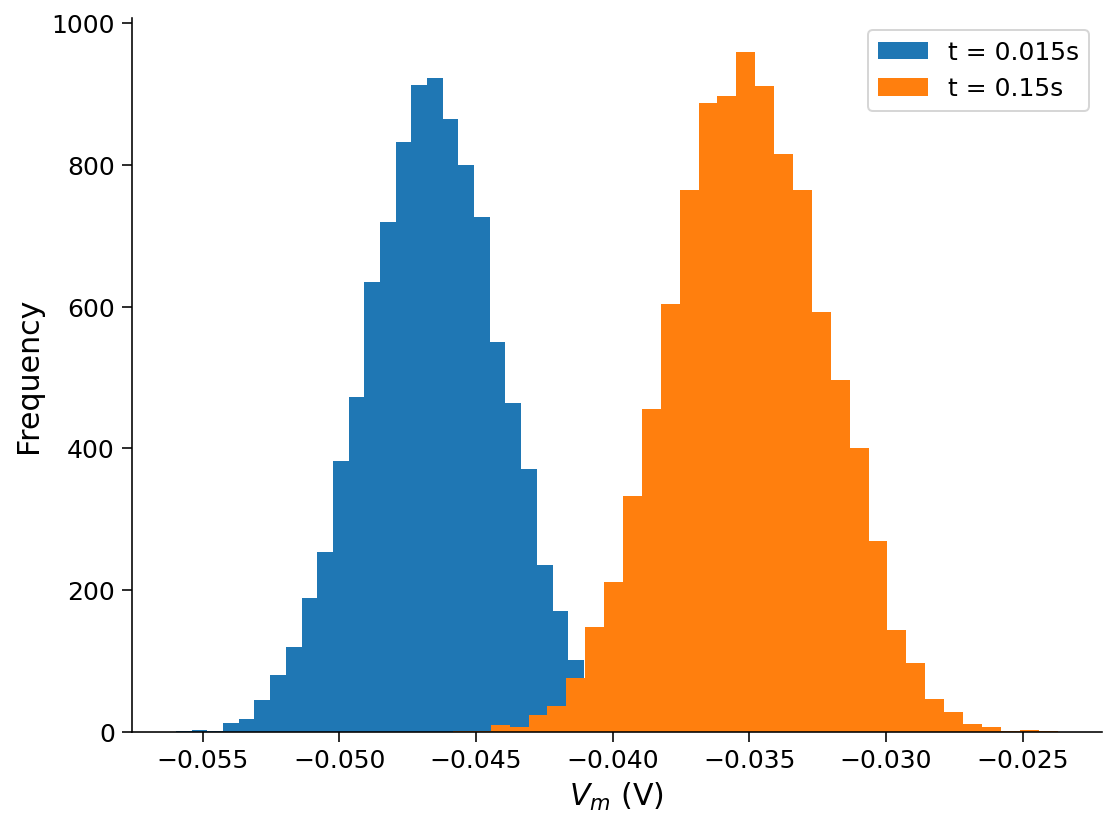

In [6]:
#################################################
## TODO for students: fill out code to plot histogram ##
# Fill out code and comment or remove the next line
#raise NotImplementedError("Student exercise: You need to plot histogram")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize t_range, step_end, n, v_n, i and nbins
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 10000
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))
nbins = 32

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:, step] =  v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r * i[:, step])

# Initialize the figure
plt.figure()
plt.ylabel('Frequency')
plt.xlabel('$V_m$ (V)')

# Plot a histogram at t_max/10 (add labels and parameters histtype='stepfilled' and linewidth=0)
plt.hist(v_n[:,int(step_end/10)], nbins, 
         histtype='stepfilled', linewidth=0,
         label='t = ' + str(t_max/10) + 's')

# Plot a histogram at t_max (add labels and parameters histtype='stepfilled' and linewidth=0)
plt.hist(v_n[:,-1], nbins,
         histtype='stepfilled', linewidth=0,
         label='t = ' + str(t_max) + 's')

# Add legend
plt.legend()
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_04b855a3.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=415 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_04b855a3_0.png>



---
# Section 2: Dictionaries & introducing spikes


In [7]:
# @title Video 3: Dictionaries & introducing spikes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1H54y1q7oS", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ioKkiukDkNg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

A spike takes place whenever $V(t)$ crosses $V_{th}$. In that case, a spike is recorded and $V(t)$ resets to $V_{reset}$ value. This is summarized in the *reset condition*:
$$V(t) = V_{reset}\quad \text{ if } V(t)\geq V_{th}$$

For more information about spikes or action potentials see [here](https://en.wikipedia.org/wiki/Action_potential) and [here](https://www.khanacademy.org/test-prep/mcat/organ-systems/neuron-membrane-potentials/a/neuron-action-potentials-the-creation-of-a-brain-signal).


![spikes cartoon](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_carton.png)

In [8]:
# @title Video 4: Nano recap of dictionaries
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1GC4y1h7hi", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="nvpHtzuZggg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 2: Adding spiking to the LIF neuron

Insert the reset condition, and collect the spike times of each realization in a dictionary variable `spikes`, with $N=500$.

We've used `plt.plot` for plotting lines and also for plotting dots at `(x,y)` coordinates, which is a [scatter plot](https://en.wikipedia.org/wiki/Scatter_plot). From here on, we'll use use `plt.plot` for plotting lines and for scatter plots: `plt.scatter`.
```
plt.scatter(x, y, color="k", marker=".")
```

A *raster plot* represents spikes from multiple neurons by plotting dots at spike times from neuron `j` at plot height `j`, i.e. 
```
plt.scatter(spike_times, j*np.ones_like(spike_times))
```

![spikes plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_plot.png)

In this exercise, we use `plt.subplot` for multiple plots in the same figure. These plots can share the same `x` or `y` axis by specifying the parameter `sharex` or `sharey`. Add `plt.tight_layout()` at the end to automatically adjust subplot parameters to fit the figure area better. Please see the example below for a row of two plots sharing axis `y`.
```
# initialize the figure
plt.figure()

# collect axis of 1st figure in ax1
ax1 = plt.subplot(1, 2, 1)
plt.plot(t_range, my_data_left)
plt.ylabel('ylabel')

# share axis x with 1st figure
plt.subplot(1, 2, 2, sharey=ax1)
plt.plot(t_range, my_data_right)

# automatically adjust subplot parameters to figure
plt.tight_layout()
```


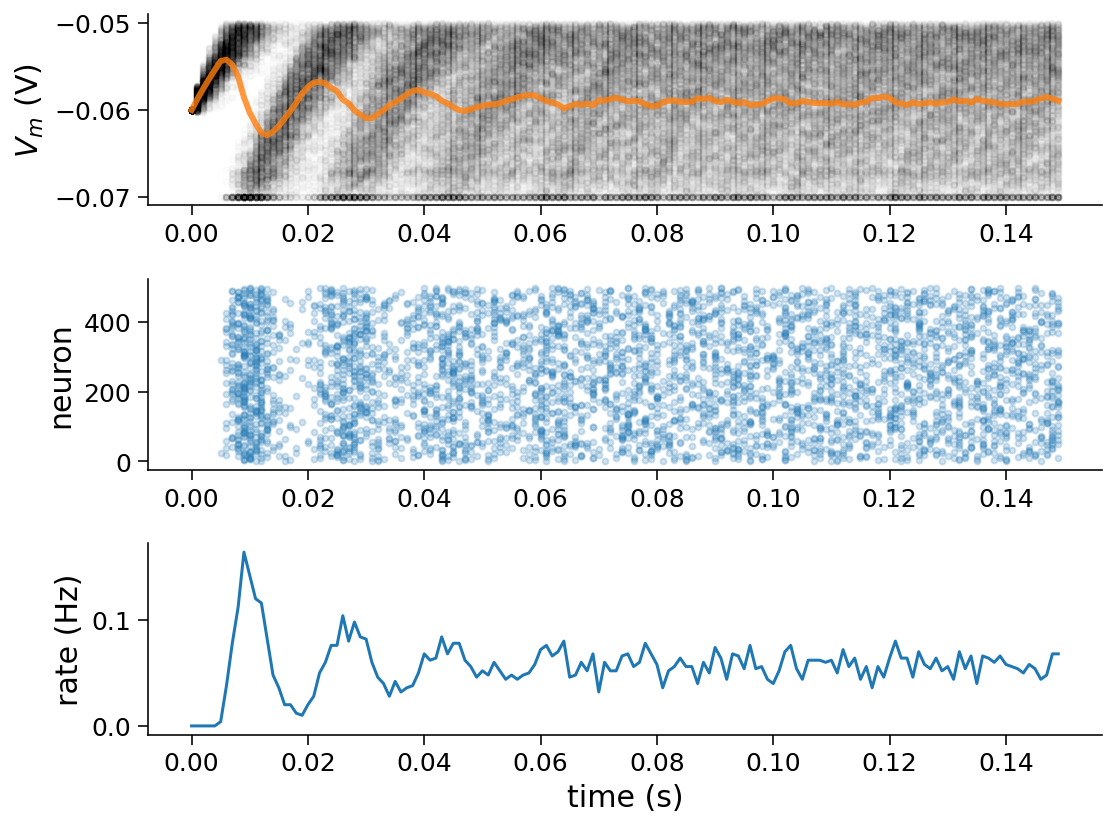

In [9]:
# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

#################################################
## TODO for students: add spikes to LIF neuron ##
# Fill out function and remove
# raise NotImplementedError("Student exercise: add spikes to LIF neuron")
#################################################

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*i[:, step])

  # Loop over simulations
  for j in range(n):

    # Check if voltage above threshold
    if v_n[j, step] >= vth:

      # Reset to reset voltage
      v_n[j, step] = vr

      # Add this spike time
      spikes[j] += [t]

      # Add spike count to this step
      spikes_n[step] += 1

# Collect mean Vm and mean spiking rate
v_mean = np.mean(v_n, axis=0)
spikes_mean =  spikes_n / n

# Initialize the figure
plt.figure()

# Plot simulations and sample mean
ax1 = plt.subplot(3, 1, 1)
for j in range(n):
  plt.scatter(t_range, v_n[j], color="k", marker=".", alpha=0.01)
plt.plot(t_range, v_mean, 'C1', alpha=0.8, linewidth=3)
plt.ylabel('$V_m$ (V)')

# Plot spikes
plt.subplot(3, 1, 2, sharex=ax1)
# for each neuron j: collect spike times and plot them at height j
for j in range(n):
  times = spikes[j]
  plt.scatter(times, j*np.ones_like(times),
              color="C0", marker=".", alpha=0.2)

plt.ylabel('neuron')

# Plot firing rate
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_range, spikes_mean)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_9aaee1d8.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_9aaee1d8_0.png>



---
# Section 3: Boolean indexes


In [10]:
# @title Video 5: Boolean indexes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1W54y1q7eh", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="G0C1v848I9Y", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Numpy arrays can be indexed by boolean arrays to select a subset of elements (also works with lists of booleans).

The boolean array itself can be initiated by a condition, as shown in the example below.
```
a = np.array([1, 2, 3])
b = a>=2
print(b)
--> [False  True  True]

print(a[b])
--> [2 3]

print(a[a>=2])
--> [2 3]
```

In [11]:
# @title Video 6: Nano recap of Boolean indexes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1W54y1q7gi", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="dFPgO5wnyLc", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 3: Using Boolean indexing

We can avoid looping all neurons in each time step by identifying with boolean arrays the indexes of neurons that spiked in the previous step.

In the example below, `v_rest` is a boolean numpy array with `True` in each index of `v_n` with value `vr` at time index `step`:

    v_rest = (v_n[:,step] == vr)
    print(v_n[v_rest,step])
    
    --> [vr, ..., vr]

The function `np.where` returns indexes of boolean arrays with `True` values.

You may use the helper function `plot_all` that implements the figure from the previous exercise.



In [12]:
help(plot_all)

Help on function plot_all in module __main__:

plot_all(t_range, v, raster=None, spikes=None, spikes_mean=None)
    Plots Time evolution for
    (1) multiple realizations of membrane potential
    (2) spikes
    (3) mean spike rate (optional)
    
    Args:
      t_range (numpy array of floats)
          range of time steps for the plots of shape (time steps)
    
      v (numpy array of floats)
          membrane potential values of shape (neurons, time steps)
    
      raster (numpy array of floats)
          spike raster of shape (neurons, time steps)
    
      spikes (dictionary of lists)
          list with spike times indexed by neuron number
    
      spikes_mean (numpy array of floats)
          Mean spike rate for spikes as dictionary
    
    Returns:
      Nothing.



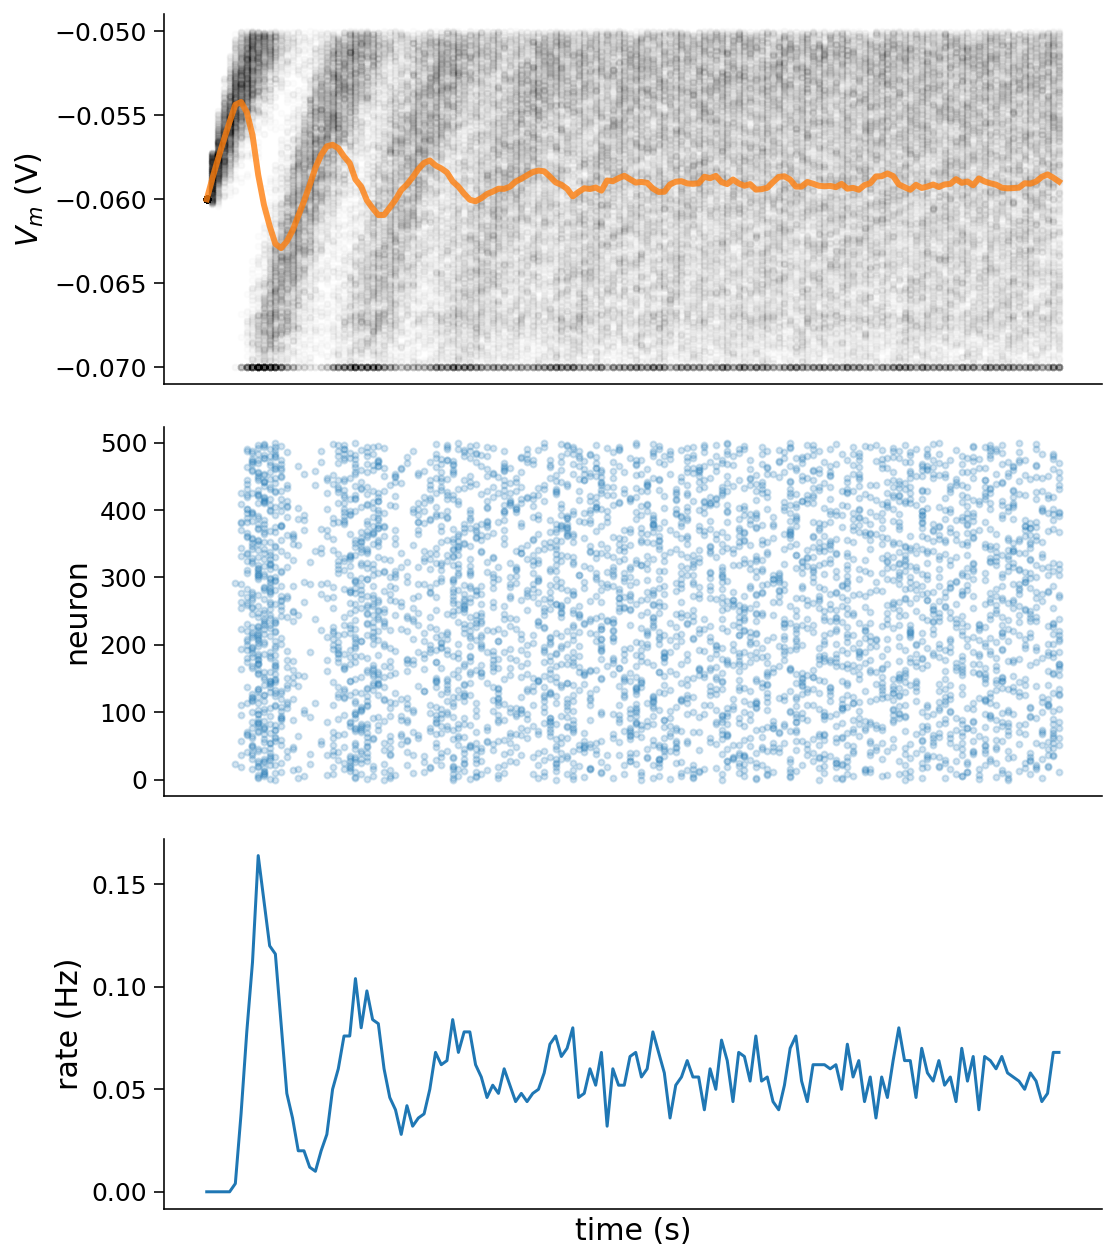

In [13]:
# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize spikes and spikes_n
spikes = {j: [] for j in range(n)}
spikes_n = np.zeros([step_end])

#################################################
## TODO for students: use Boolean indexing ##
# Fill out function and remove
# raise NotImplementedError("Student exercise: using Boolean indexing")
#################################################

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*i[:, step])

  # Initialize boolean numpy array `spiked` with v_n > v_thr
  spiked = (v_n[:, step] > vth)

  # Set relevant values of v_n to resting potential using spiked
  v_n[spiked,step] = vr

  v_rest = (v_n[:,step] == vr)

  # Collect spike times
  for j in np.where(spiked)[0]:
    spikes[j] += [t]
    spikes_n[step] += 1

# Collect mean spiking rate
spikes_mean = spikes_n / n

# Plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, spikes=spikes, spikes_mean=spikes_mean)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_9daa0f41.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=632 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_9daa0f41_0.png>



## Coding Exercise 4: Making a binary raster plot
A *binary raster plot* represents spike times as `1`s in a binary grid initialized with `0`s. We start with a numpy array `raster` of zeros with shape `(neurons, time steps)`, and represent a spike from neuron `5` at time step `20` as `raster(5,20)=1`, for example.

The *binary raster plot* is much more efficient than the previous method by plotting the numpy array `raster` as an image:
```
plt.imshow(raster, cmap='Greys', origin='lower', aspect='auto')
```

**Suggestions**
* At each time step:
  * Initialize boolean numpy array `spiked` with $V_n(t)\geq V_{th}$
  * Set to `vr` indexes of `v_n` using `spiked`
  * Set to `1` indexes of numpy array `raster` using `spiked`

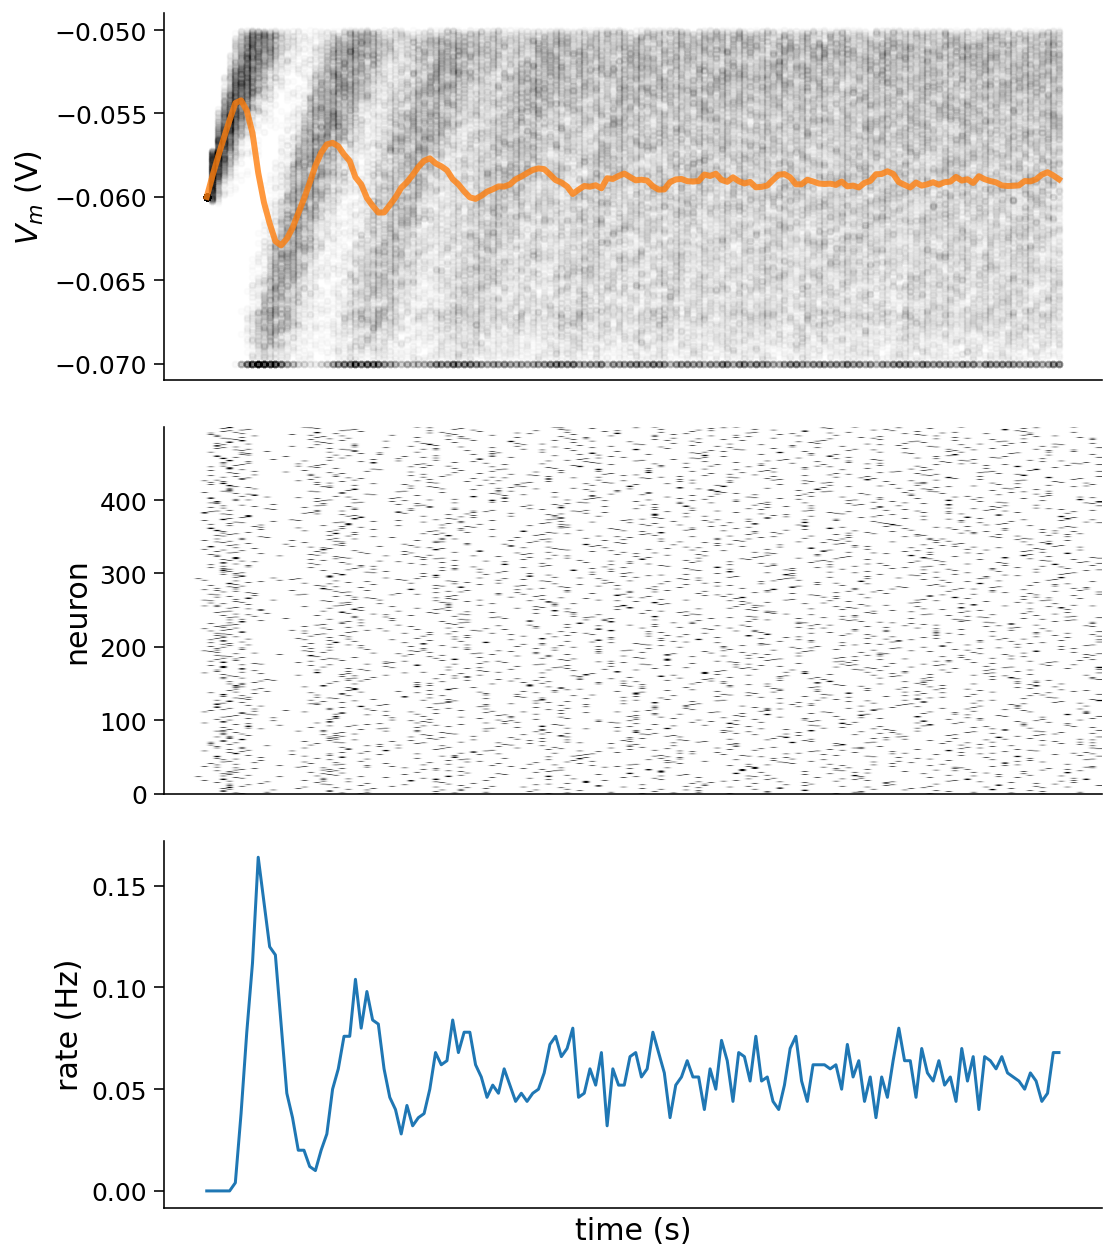

In [14]:
#################################################
## TODO for students: make a raster ##
# Fill out function and remove
# raise NotImplementedError("Student exercise: make a raster ")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*i[:, step])

  # Initialize boolean numpy array `spiked` with v_n > v_thr
  spiked = (v_n[:,step] >= vth)

  # Set relevant values of v_n to v_reset using spiked
  v_n[spiked,step] = vr

  # Set relevant elements in raster to 1 using spiked
  raster[spiked,step] = 1

# Plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_3973c4c4.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=632 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_3973c4c4_0.png>



---
# Section 4: Refractory period



In [15]:
# @title Video 7: Refractory period
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1MT4y1E79j", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="KVNdbRY5-nY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

The absolute refractory period is a time interval in the order of a few milliseconds during which synaptic input will not lead to a 2nd spike, no matter how strong. This effect is due to the biophysics of the neuron membrane channels, and you can read more about absolute and relative refractory period [here](https://content.byui.edu/file/a236934c-3c60-4fe9-90aa-d343b3e3a640/1/module5/readings/refractory_periods.html) and [here](https://en.wikipedia.org/wiki/Refractory_period_(physiology)).

![refractory period plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/refractory_period.png)

In [16]:
# @title Video 8: Nano recap of refractory period
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1pA411e7je", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="DOoftC0JU2k", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 5: Investigating refactory periods
Investigate the effect of (absolute) refractory period $t_{ref}$ on the evolution of output rate $\lambda(t)$. Add refractory period $t_{ref}=10$ ms after each spike, during which $V(t)$ is clamped to $V_{reset}$.




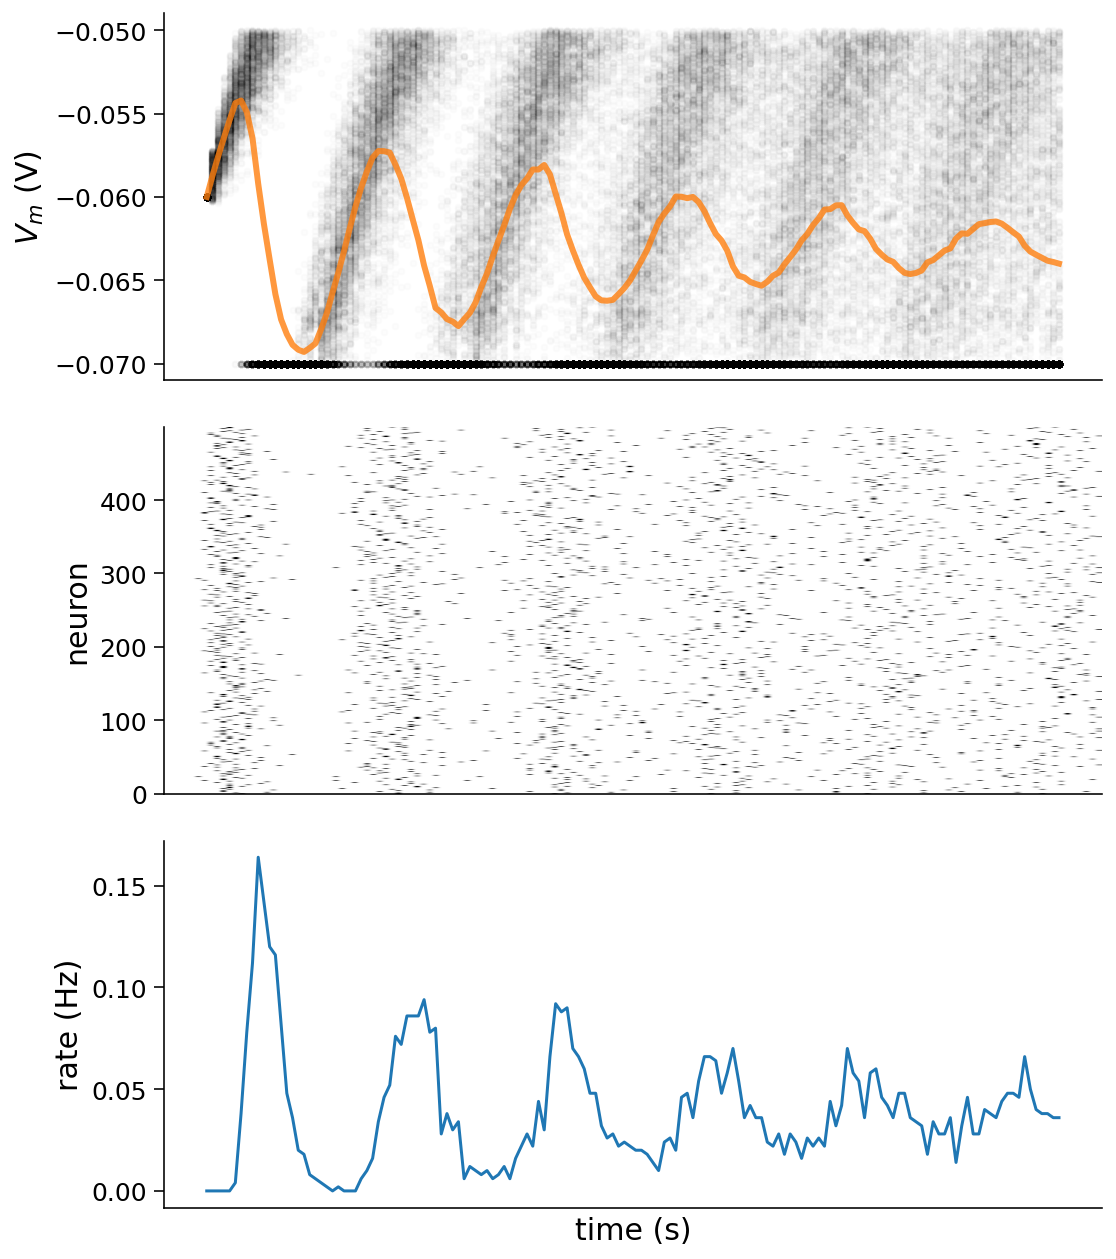

In [20]:
#################################################
## TODO for students: add refactory period ##
# Fill out function and remove
#raise NotImplementedError("Student exercise: add refactory period ")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Initialize t_ref and last_spike
t_ref = 0.01
last_spike = -t_ref * np.ones([n])

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r*i[:, step])

  # Initialize boolean numpy array `spiked` with v_n > v_thr
  spiked = (v_n[:,step] >= vth)

  # Set relevant values of v_n to v_reset using spiked
  v_n[spiked,step] = vr

  # Set relevant elements in raster to 1 using spiked
  raster[spiked,step] = 1

  # Initialize boolean numpy array clamped using last_spike, t and t_ref
  clamped = last_spike + t_ref > t

  # Reset clamped neurons to vr using clamped
  v_n[clamped,step] = vr

  # Update numpy array last_spike with time t for spiking neurons
  last_spike[spiked] = t

# Plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_81ef8269.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=632 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_81ef8269_0.png>



## Interactive Demo 1: Random refractory period
In the following interactive demo, we will investigate the effect of random refractory periods. We will use random refactory periods $t_{ref}$ with 
$t_{ref} = \mu + \sigma\,\mathcal{N}$, where $\mathcal{N}$ is the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), $\mu=0.01$ and $\sigma=0.007$.

Refractory period samples `t_ref` of size `n` is initialized with `np.random.normal`. We clip negative values to `0` with boolean indexes. (Why?) You can double click the cell to see the hidden code.

You can play with the parameters mu and sigma and visualize the resulting simulation. 
What is the effect of different $\sigma$ values?


In [ ]:
# @markdown Execute this cell to enable the demo

def random_ref_period(mu, sigma):
  # set random number generator
  np.random.seed(2020)

  # initialize step_end, t_range, n, v_n, syn and raster
  t_range = np.arange(0, t_max, dt)
  step_end = len(t_range)
  n = 500
  v_n = el * np.ones([n,step_end])
  syn = i_mean * (1 + 0.1*(t_max/dt)**(0.5)*(2*np.random.random([n,step_end])-1))
  raster = np.zeros([n,step_end])

  # initialize t_ref and last_spike
  t_ref = mu + sigma*np.random.normal(size=n)
  t_ref[t_ref<0] = 0
  last_spike = -t_ref * np.ones([n])

  # loop time steps
  for step, t in enumerate(t_range):
    if step==0:
      continue

    v_n[:,step] = v_n[:,step-1] + dt/tau * (el - v_n[:,step-1] + r*syn[:,step])

    # boolean array spiked indexes neurons with v>=vth
    spiked = (v_n[:,step] >= vth)
    v_n[spiked,step] = vr
    raster[spiked,step] = 1.

    # boolean array clamped indexes refractory neurons
    clamped = (last_spike + t_ref > t)
    v_n[clamped,step] = vr
    last_spike[spiked] = t

  # plot multiple realizations of Vm, spikes and mean spike rate
  plot_all(t_range, v_n, raster)

  # plot histogram of t_ref
  plt.figure(figsize=(8,4))
  plt.hist(t_ref, bins=32, histtype='stepfilled', linewidth=0, color='C1')
  plt.xlabel(r'$t_{ref}$ (s)')
  plt.ylabel('count')
  plt.tight_layout()

_ = widgets.interact(random_ref_period, mu = (0.01, 0.05, 0.01), \
                              sigma = (0.001, 0.02, 0.001))

---
# Section 5: Using functions
Running key parts of your code inside functions improves your coding narrative by making it clearer and more flexible to future changes.

In [ ]:
# @title Video 9: Functions
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1sa4y1a7pq", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="mkf8riqCjS4", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In [ ]:
# @title Video 10: Nano recap of functions
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1pz411v74H", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="0An_NnVWY_Q", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 6: Rewriting code with functions
We will now re-organize parts of the code from the previous exercise with functions. You need to complete the function `spike_clamp()` to update $V(t)$ and deal with spiking and refractoriness

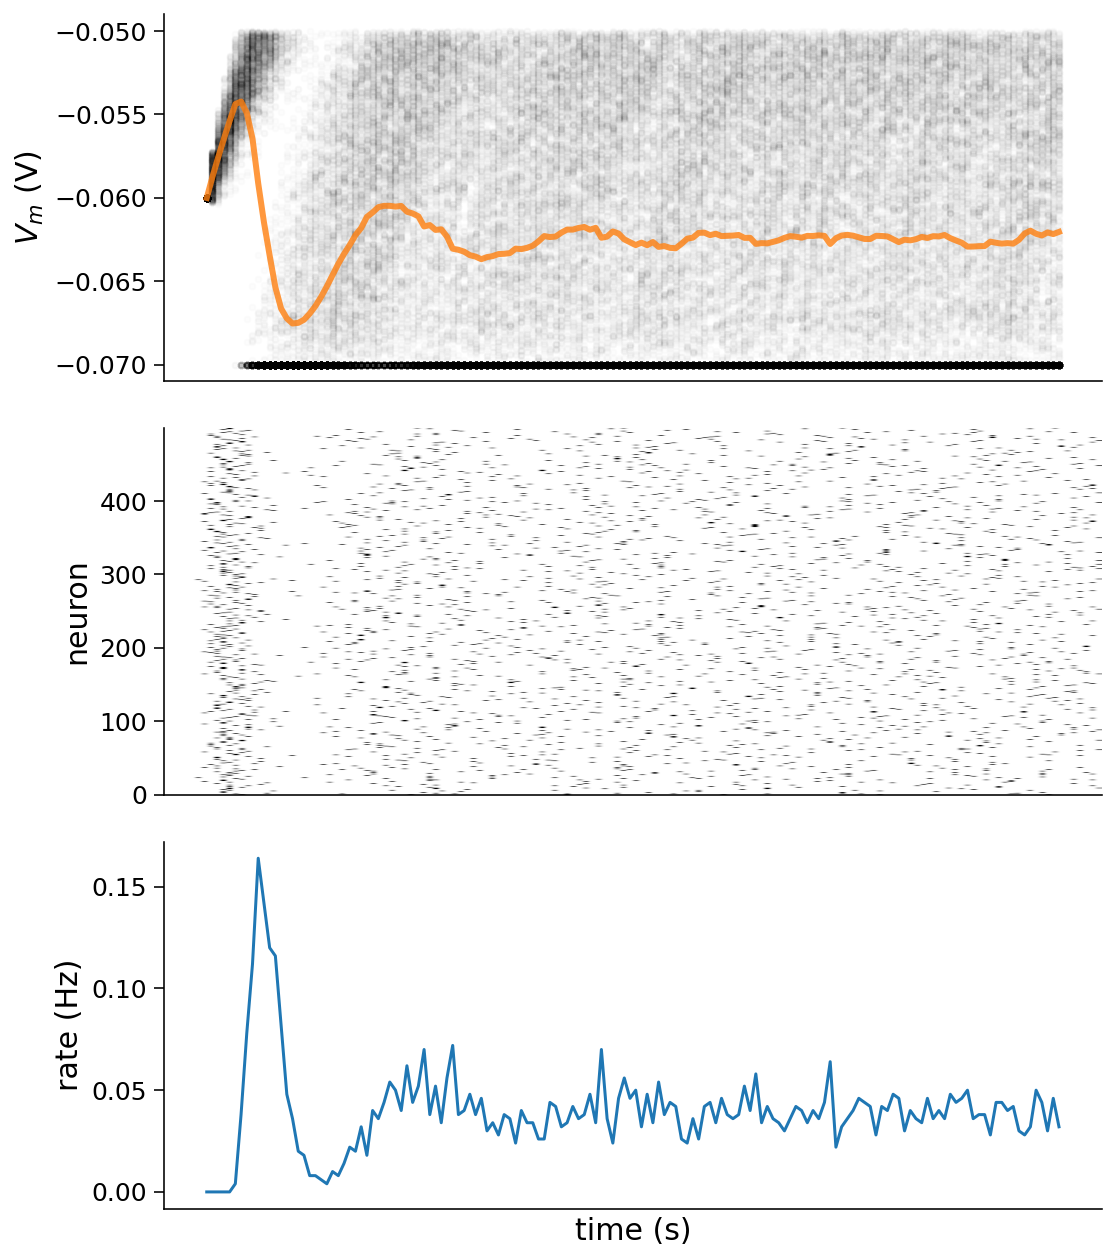

In [21]:
def ode_step(v, i, dt):
  """
  Evolves membrane potential by one step of discrete time integration

  Args:
    v (numpy array of floats)
      membrane potential at previous time step of shape (neurons)

    i (numpy array of floats)
      synaptic input at current time step of shape (neurons)

    dt (float)
      time step increment

  Returns:
    v (numpy array of floats)
      membrane potential at current time step of shape (neurons)
  """
  v = v + dt/tau * (el - v + r*i)

  return v

def spike_clamp(v, delta_spike):
  """
  Resets membrane potential of neurons if v>= vth
  and clamps to vr if interval of time since last spike < t_ref

  Args:
    v (numpy array of floats)
      membrane potential of shape (neurons)

    delta_spike (numpy array of floats)
      interval of time since last spike of shape (neurons)

  Returns:
    v (numpy array of floats)
      membrane potential of shape (neurons)
    spiked (numpy array of floats)
      boolean array of neurons that spiked  of shape (neurons)
  """

  ####################################################
  ## TODO for students: complete spike_clamp
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete spike_clamp")
  ####################################################

  # Boolean array spiked indexes neurons with v>=vth
  spiked = (v >= vth)
  v[spiked] = vr

  # Boolean array clamped indexes refractory neurons
  clamped = (delta_spike < t_ref)
  v[clamped] = vr

  return v, spiked


# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Initialize t_ref and last_spike
mu = 0.01
sigma = 0.007
t_ref = mu + sigma*np.random.normal(size=n)
t_ref[t_ref<0] = 0
last_spike = -t_ref * np.ones([n])

# Loop over time steps
for step, t in enumerate(t_range):

  # Skip first iteration
  if step==0:
    continue

  # Compute v_n
  v_n[:,step] = ode_step(v_n[:,step-1], i[:,step], dt)

  # Reset membrane potential and clamp
  v_n[:,step], spiked = spike_clamp(v_n[:,step], t - last_spike)

  # Update raster and last_spike
  raster[spiked,step] = 1.
  last_spike[spiked] = t

# Plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

---
# Section 6: Using classes


In [ ]:
# @title Video 11: Classes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1hz411v7ne", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="dGRESMoNPh0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Using classes helps with code reuse and reliability. Well-designed classes are like black boxes in that they receive inputs and provide expected outputs. The details of how the class processes inputs and produces outputs are unimportant.

See additional details here: [A Beginner's Python Tutorial/Classes](https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes)

*Attributes* are variables internal to the class, and *methods* are functions internal to the class.

In [ ]:
# @title Video 12: Nano recap of classes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV12V41167yu", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="4YNpMpVW2qs", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 7: Making a LIF class
In this exercise we'll practice with Python classes by implementing `LIFNeurons`, a class that evolves and keeps state of multiple realizations of LIF neurons.

Several attributes are used to keep state of our neurons:
```
self.v             current membrane potential
self.spiked        neurons that spiked
self.last_spike    last spike time of each neuron
self.t             running time of the simulation
self.steps         simulation step
```
There is a single method:
```
self.ode_step()    performs single step discrete time integration
                   for provided synaptic current and dt
```

Complete the spike and clamp part of method `self.ode_step` (should be similar to function `spike_and_clamp` seen before)

Ran for 0.15s in 150 steps.


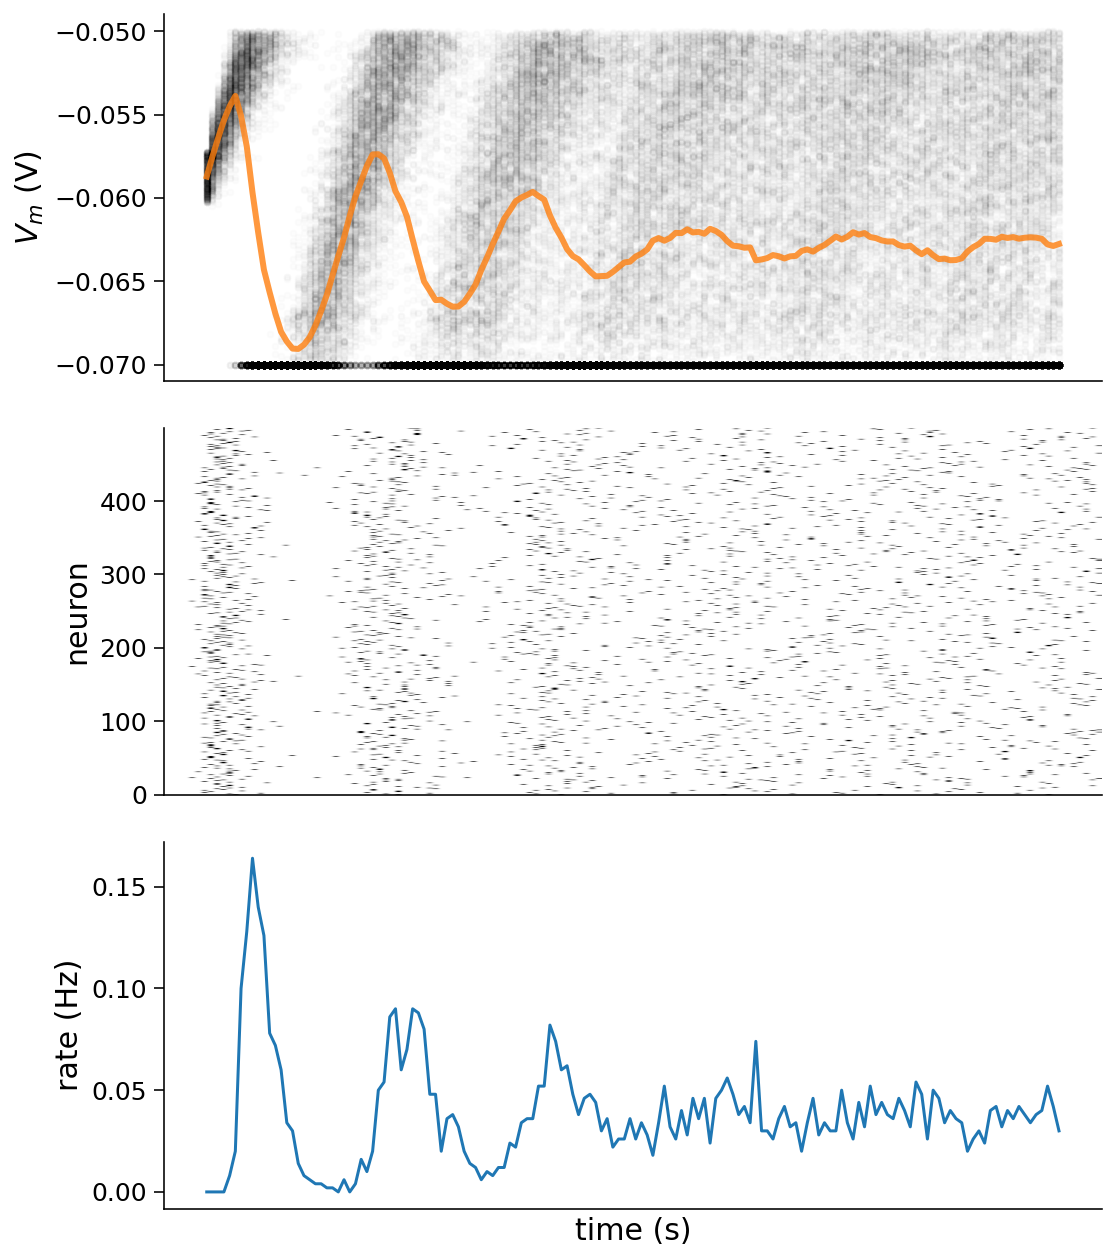

In [22]:
# Simulation class
class LIFNeurons:
  """
  Keeps track of membrane potential for multiple realizations of LIF neuron,
  and performs single step discrete time integration.
  """
  def __init__(self, n, t_ref_mu=0.01, t_ref_sigma=0.002,
               tau=20e-3, el=-60e-3, vr=-70e-3, vth=-50e-3, r=100e6):

    # Neuron count
    self.n = n

    # Neuron parameters
    self.tau = tau        # second
    self.el = el          # milivolt
    self.vr = vr          # milivolt
    self.vth = vth        # milivolt
    self.r = r            # ohm

    # Initializes refractory period distribution
    self.t_ref_mu = t_ref_mu
    self.t_ref_sigma = t_ref_sigma
    self.t_ref = self.t_ref_mu + self.t_ref_sigma * np.random.normal(size=self.n)
    self.t_ref[self.t_ref<0] = 0

    # State variables
    self.v = self.el * np.ones(self.n)
    self.spiked = self.v >= self.vth
    self.last_spike = -self.t_ref * np.ones([self.n])
    self.t = 0.
    self.steps = 0


  def ode_step(self, dt, i):

    # Update running time and steps
    self.t += dt
    self.steps += 1

    # One step of discrete time integration of dt
    self.v = self.v + dt / self.tau * (self.el - self.v + self.r * i)

    ####################################################
    ## TODO for students: complete the `ode_step` method
    # Fill out function and remove
    #raise NotImplementedError("Student exercise: complete the ode_step method")
    ####################################################

    # Spike and clamp
    self.spiked = (self.v >= self.vth)
    self.v[self.spiked] = self.vr
    self.last_spike[self.spiked] = self.t
    clamped =  (self.t_ref > self.t-self.last_spike)
    self.v[clamped] = self.vr

# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, n, v_n and i
t_range = np.arange(0, t_max, dt)
step_end = len(t_range)
n = 500
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Initialize binary numpy array for raster plot
raster = np.zeros([n,step_end])

# Initialize neurons
neurons = LIFNeurons(n)

# Loop over time steps
for step, t in enumerate(t_range):

  # Call ode_step method
  neurons.ode_step(dt, i[:,step])

  # Log v_n and spike history
  v_n[:,step] = neurons.v
  raster[neurons.spiked, step] = 1.

# Report running time and steps
print(f'Ran for {neurons.t:.3}s in {neurons.steps} steps.')

# Plot multiple realizations of Vm, spikes and mean spike rate
plot_all(t_range, v_n, raster)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D2_PythonWorkshop2/solutions/W0D2_Tutorial1_Solution_a22fdac7.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=632 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D2_PythonWorkshop2/static/W0D2_Tutorial1_Solution_a22fdac7_1.png>



---
# Summary


In [ ]:
# @title Video 12: Last concepts & recap
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1MC4y1h7eA", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="h4mSJBPocPo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)